In [2]:
# imports

import TickLoader
import numpy as np
import pandas as pd
import datetime as dt
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython import get_ipython
import matplotlib.mlab as mlab
import itertools 
from __future__ import division

/home/local/TMG/samuel.kalt/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Data pull

hrs=['03:45:01','10:54:59']
start_datetime = '2018-02-01 '+hrs[0]
end_datetime = '2018-02-25 '+hrs[1]
symbols=['CC  FMK0018!','C   FMK0018!','6BH8']


Raw_data_US=TickLoader.raw_ticks_dataframe(symbols[0], start_datetime, end_datetime,books_type='direct')
Raw_data_UK=TickLoader.raw_ticks_dataframe(symbols[1], start_datetime, end_datetime,books_type='direct')
Raw_data_GBP=TickLoader.raw_ticks_dataframe(symbols[2], start_datetime, end_datetime,books_type='direct')


TickLoader.py:404: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  args = tickp_args(filtered_symbols, start_datetime, end_datetime, tickdb_path, exchanges=exchanges)


In [4]:
Raw_data_US.trade_size.fillna(0,inplace=True)
Raw_data_UK.trade_size.fillna(0,inplace=True)

data_US = Raw_data_US.drop(['symbol','instrumentId'], 1)
data_US = data_US.rename(columns={'bid_price': 'US_bid_price','ask_price': 'US_ask_price','bid_size': 'US_bid_size',
                                 'ask_size': 'US_ask_size', 'mid': 'US_mid', 'wtd_mid': 'US_wtd_mid',
                                 'trade_price':'US_trade_price','trade_size':'US_trade_size',
                                 'bid_orders':'US_bid_orders','ask_orders':'US_ask_orders'})

data_UK = Raw_data_UK.drop(['symbol','instrumentId'], 1)
data_UK = data_UK.rename(columns={'bid_price': 'UK_bid_price','ask_price': 'UK_ask_price','bid_size': 'UK_bid_size',
                                 'ask_size': 'UK_ask_size', 'mid': 'UK_mid', 'wtd_mid': 'UK_wtd_mid',
                                 'trade_price':'UK_trade_price','trade_size':'UK_trade_size',
                                 'bid_orders':'UK_bid_orders','ask_orders':'UK_ask_orders'})

data_GBP = Raw_data_GBP.drop(['symbol','instrumentId','trade_price','bid_orders','ask_orders'], 1)
data_GBP = data_GBP.rename(columns={'bid_price': 'GBP_bid_price','ask_price': 'GBP_ask_price','bid_size': 'GBP_bid_size',
                                 'ask_size': 'GBP_ask_size', 'mid': 'GBP_mid', 'wtd_mid': 'GBP_wtd_mid',
                                   'trade_price':'GBP_trade_price','trade_size':'GBP_trade_size',})

dataDF=data_US.join(data_UK,how='outer').join(data_GBP,how='outer')


dataDF[['US_bid_price','US_ask_price','US_bid_size',
    'US_ask_size', 'US_mid','US_wtd_mid',
    'US_bid_orders','US_ask_orders']]=dataDF[['US_bid_price','US_ask_price','US_bid_size',
    'US_ask_size', 'US_mid','US_wtd_mid',
    'US_bid_orders','US_ask_orders']].ffill().bfill()

dataDF[['UK_bid_price','UK_ask_price','UK_bid_size',
    'UK_ask_size', 'UK_mid','UK_wtd_mid',
    'UK_bid_orders','UK_ask_orders']]=dataDF[['UK_bid_price','UK_ask_price','UK_bid_size',
    'UK_ask_size', 'UK_mid','UK_wtd_mid',
    'UK_bid_orders','UK_ask_orders']].ffill().bfill()

dataDF[['GBP_bid_price','GBP_ask_price','GBP_bid_size',
    'GBP_ask_size', 'GBP_mid','UK_wtd_mid']]= dataDF[['GBP_bid_price',
    'GBP_ask_price','GBP_bid_size','GBP_ask_size', 
    'GBP_mid','GBP_wtd_mid']].ffill().bfill()

In [5]:
# Compute arb prices
dataDF['arb_mid']=dataDF.US_mid-dataDF.UK_mid*dataDF.GBP_mid/10000
dataDF['arb_bid']=dataDF.US_bid_price-dataDF.UK_ask_price*dataDF.GBP_mid/10000
dataDF['arb_ask']=dataDF.US_ask_price-dataDF.UK_bid_price*dataDF.GBP_mid/10000

In [6]:
#compute Liquidity taking

dataDF['US_hitting']=0
dataDF['US_hitting'][(dataDF['US_trade_size'] > 0) & (dataDF['US_trade_price'] == dataDF['US_bid_price'])] = dataDF['US_trade_size']
dataDF['US_hitting_cum']=dataDF['US_hitting'].cumsum()

dataDF['US_liftting']=0
dataDF['US_liftting'][(dataDF['US_trade_size'] > 0) & (dataDF['US_trade_price'] == dataDF['US_ask_price'])] = dataDF['US_trade_size']
dataDF['US_liftting_cum']=dataDF['US_liftting'].cumsum()

dataDF['UK_hitting']=0
dataDF['UK_hitting'][(dataDF['UK_trade_size'] > 0) & (dataDF['UK_trade_price'] == dataDF['UK_bid_price'])] = dataDF['UK_trade_size']
dataDF['UK_hitting_cum']=dataDF['UK_hitting'].cumsum()

dataDF['UK_liftting']=0
dataDF['UK_liftting'][(dataDF['UK_trade_size'] > 0) & (dataDF['UK_trade_price'] == dataDF['UK_ask_price'])] = dataDF['UK_trade_size']
dataDF['UK_liftting_cum']=dataDF['UK_liftting'].cumsum()


/home/local/TMG/samuel.kalt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/local/TMG/samuel.kalt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/local/TMG/samuel.kalt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/local/TMG/s

In [7]:
# resampling
dataDF=dataDF.resample('1S').last().ffill()

#cleaning
dataDF = dataDF.between_time('03:45','10:55')
dataDF['weekday']=[x.weekday() for x in dataDF.index]
dataDF=dataDF[dataDF['weekday']!=5]
dataDF=dataDF[dataDF['weekday']!=6]
# US closed
dataDF=dataDF[(dataDF.index < '2018-02-19') | (dataDF.index > '2018-02-20')]


# resampled volumes
dataDF['US_hitting']=dataDF['US_hitting_cum'].diff(1)
dataDF['US_liftting']=dataDF['US_liftting_cum'].diff(1)
dataDF['UK_hitting']=dataDF['UK_hitting_cum'].diff(1)
dataDF['UK_liftting']=dataDF['UK_liftting_cum'].diff(1)

# future arb moves (Y)
dataDF['arb_move']= dataDF['arb_mid'].diff(-5*60)

#future outright moves
dataDF['US_move']= dataDF['US_mid'].diff(-5*60)
dataDF['UK_move']= dataDF['UK_mid'].diff(-5*60)

# explanatory variables (X)
# liquidity taking
dataDF['US_recent_hitting']=dataDF['US_hitting'].rolling('300S').sum()
dataDF['UK_recent_hitting']=dataDF['UK_hitting'].rolling('300S').sum()
dataDF['US_recent_liftting']=dataDF['US_liftting'].rolling('300S').sum()
dataDF['UK_recent_liftting']=dataDF['UK_liftting'].rolling('300S').sum()

# recent cvd
dataDF['US_recent_cvd']=dataDF['US_recent_liftting']-dataDF['US_recent_hitting']
dataDF['UK_recent_cvd']=dataDF['UK_recent_liftting']-dataDF['UK_recent_hitting']

#rsi (relatice strength index)
dataDF['US_delt']=dataDF['US_mid'].diff()
dataDF['US_delt'][(dataDF['US_delt']>5) |(dataDF['US_delt']<-5) ]=0
dataDF['US_delt_up']=dataDF['US_delt'][dataDF['US_delt']>0]
dataDF['US_delt_down']=-dataDF['US_delt'][dataDF['US_delt']<0]
dataDF['US_rs']= dataDF['US_delt_up'].rolling('1200S').mean()/dataDF['US_delt_down'].rolling('1200S').mean()
dataDF['US_rsi']=100-100/(1+dataDF['US_rs'])

dataDF['UK_delt']=dataDF['UK_mid'].diff()
dataDF['UK_delt'][(dataDF['UK_delt']>5) |(dataDF['UK_delt']<-5) ]=0
dataDF['UK_delt_up']=dataDF['UK_delt'][dataDF['UK_delt']>0]
dataDF['UK_delt_down']=-dataDF['UK_delt'][dataDF['UK_delt']<0]
dataDF['UK_rs']= dataDF['UK_delt_up'].rolling('1200S').mean()/dataDF['UK_delt_down'].rolling('1200S').mean()
dataDF['UK_rsi']=100-100/(1+dataDF['UK_rs'])

#so (stochastic oscillator)
dataDF['US_so']=(dataDF['US_mid'].rolling('20H').max()-
                 dataDF['US_mid'])*(-100)/(dataDF['US_mid'].rolling('20H').max()-dataDF['US_mid'].rolling('10H').min())

dataDF['UK_so']=(dataDF['UK_mid'].rolling('20H').max()-
                 dataDF['UK_mid'])*(-100)/(dataDF['UK_mid'].rolling('20H').max()-dataDF['UK_mid'].rolling('10H').min())

#proc (price rate of change)
dataDF['US_proc']=dataDF['US_mid'].diff(2400)/dataDF['US_mid'].shift(2400)
dataDF['UK_proc']=dataDF['UK_mid'].diff(2400)/dataDF['UK_mid'].shift(2400)

#macd (moving average convergence divergence)
dataDF['US_ema_12'] = pd.ewma(dataDF['US_mid'], span=12*60*60)
dataDF['US_ema_26'] = pd.ewma(dataDF['US_mid'], span=26*60*60)
dataDF['US_macd']=dataDF['US_ema_12']-dataDF['US_ema_26']
dataDF['US_macd_sl']= pd.ewma(dataDF['US_macd'], span=9*60*60)
dataDF['US_macd_signal']= np.sign(dataDF['US_macd']-dataDF['US_macd_sl'])
dataDF['US_macd_signal']= dataDF['US_macd_signal'].diff()
dataDF['US_macd_signal']= np.sign(dataDF['US_macd_signal'])

dataDF['UK_ema_12'] = pd.ewma(dataDF['UK_mid'], span=12*60*60)
dataDF['UK_ema_26'] = pd.ewma(dataDF['UK_mid'], span=26*60*60)
dataDF['UK_macd']=dataDF['UK_ema_12']-dataDF['UK_ema_26']
dataDF['UK_macd_sl']= pd.ewma(dataDF['UK_macd'], span=9*60*60)
dataDF['UK_macd_signal']= np.sign(dataDF['UK_macd']-dataDF['UK_macd_sl'])
dataDF['UK_macd_signal']= dataDF['UK_macd_signal'].diff()
dataDF['UK_macd_signal']= np.sign(dataDF['UK_macd_signal'])



dataDF['US_rsi'].fillna(0.0, inplace=True)
dataDF['UK_rsi'].fillna(0.0, inplace=True)
dataDF['US_so'].fillna(-50.0, inplace=True)
dataDF['UK_so'].fillna(-50.0, inplace=True)
dataDF['US_proc'].fillna(0.0, inplace=True)
dataDF['UK_proc'].fillna(0.0, inplace=True)
dataDF['US_macd_signal'].fillna(0.0, inplace=True)
dataDF['UK_macd_signal'].fillna(0.0, inplace=True)
dataDF['arb_move'].fillna(0.0, inplace=True)
dataDF['US_move'].fillna(0.0, inplace=True)
dataDF['UK_move'].fillna(0.0, inplace=True)



/home/local/TMG/samuel.kalt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/local/TMG/samuel.kalt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/local/TMG/samuel.kalt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:64: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=43200,min_periods=0,adjust=True).mean()
/home/local/TMG/samuel.kalt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:65: FutureWarning: pd.ewm_me

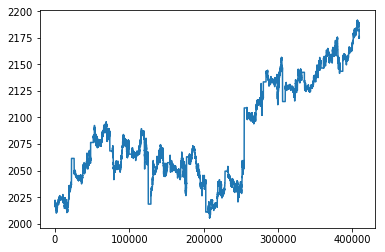

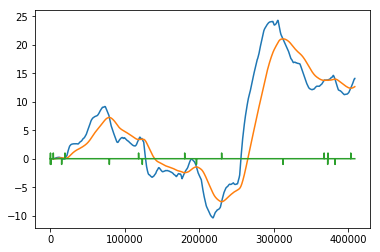

In [33]:
t=range(1,len(dataDF['US_recent_hitting'])+1)

plt.plot(t,dataDF['US_mid'])
plt.show()
plt.plot(t,dataDF['US_macd'])
plt.plot(t,dataDF['US_macd_sl'])
plt.plot(t,dataDF['US_macd_signal'])
plt.show()

In [34]:
# multiple linear regression
import statsmodels.api as sm

X=dataDF[['US_rsi','UK_rsi','US_so','UK_so','US_proc','UK_proc','US_macd_signal','UK_macd_signal']]
Y=dataDF['arb_move']

model=sm.OLS(Y,X)
results=model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               arb_move   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     309.6
Date:                Wed, 21 Mar 2018   Prob (F-statistic):               0.00
Time:                        07:35:12   Log-Likelihood:            -8.7561e+05
No. Observations:              409220   AIC:                         1.751e+06
Df Residuals:                  409212   BIC:                         1.751e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
US_rsi             0.0030      0.000      9.

In [36]:
# Decision trees
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV


X=dataDF[['US_rsi','UK_rsi','US_so','UK_so','US_proc','UK_proc','US_macd_signal','UK_macd_signal']]
Y=[1 if x>1 else 0 for x in dataDF['arb_move']] 

X_train, X_test, Y_train, Y_test = train_test_split(X,Y)

model=DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, 
                             random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                             min_impurity_split=None, class_weight=None, presort=False)


pipeline = Pipeline([('clf', model )])

parameters = {
    'clf__max_depth': (5,7,10),
    'clf__min_samples_split': (2,3,4),
    'clf__min_samples_leaf': (1,2,3)
}

grid_search = GridSearchCV(pipeline,parameters,n_jobs=1,verbose=1,scoring='f1')

grid_search.fit(X_train,Y_train)

print 'Best score: %0.3f' % grid_search.best_score_

print 'Best parameters set: '
best_parameters=grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()): 
    print '\t%s: %r' % (param_name, best_parameters[param_name])
    
predictions = grid_search.predict(X_test)
print classification_report(Y_test,predictions)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:   54.7s finished


Best score: 0.315
Best parameters set: 
	clf__max_depth: 10
	clf__min_samples_leaf: 1
	clf__min_samples_split: 2
             precision    recall  f1-score   support

          0       0.83      0.98      0.90     82065
          1       0.74      0.21      0.32     20240

avg / total       0.81      0.83      0.79    102305



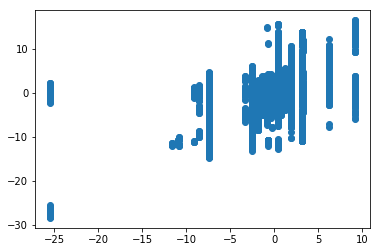

{'presort': False, 'splitter': 'best', 'min_impurity_decrease': 0.0, 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.001, 'criterion': 'mse', 'random_state': None, 'min_impurity_split': None, 'max_features': None, 'max_depth': 5}
[ 0.10875204  0.22226315  0.17584301  0.1381615   0.2155039   0.1394764   0.
  0.        ]
['US_rsi' 'UK_rsi' 'US_so' 'UK_so' 'US_proc' 'UK_proc' 'US_macd_signal'
 'UK_macd_signal']
8
8
-0.328627852971
[ 0.10616887  0.10033323  0.08800873  0.09560575  0.10062928]
score: 0.10 (+/- 0.01)


In [208]:
# Decision trees Regression

from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing

X=dataDF[['US_rsi','UK_rsi','US_so','UK_so','US_proc','UK_proc','US_macd_signal','UK_macd_signal']]
Y=dataDF['arb_move']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)



model = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=5, min_samples_split=10, min_samples_leaf=10, 
         min_weight_fraction_leaf=0.001, max_features=None, random_state=None, max_leaf_nodes=None, 
         min_impurity_decrease=0.0, min_impurity_split=None, presort=False)


sample_weights=abs(Y_train)
sample_weights=np.array(sample_weights, dtype=pd.Series)

# data transformation 
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)

model.fit(X_train_transformed,Y_train, sample_weight=sample_weights, check_input=True, X_idx_sorted=None)

predictions = model.predict(X_test_transformed)

plt.scatter(predictions,Y_test)
plt.show()

print model.get_params()
print model.feature_importances_
print X.columns.values
print model.max_features_
print model.n_features_
print model.tree_
print model.score(X_test_transformed,Y_test)

# cross-validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='explained_variance')
print scores  
print("score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))



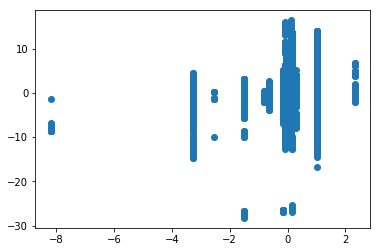

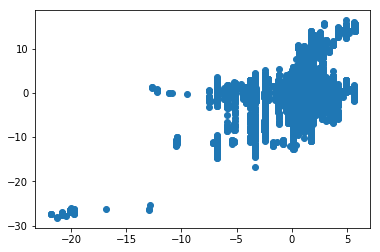

In [213]:
# Decision trees Regression with AdaBoost

from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.ensemble import AdaBoostRegressor

X=dataDF[['US_rsi','UK_rsi','US_so','UK_so','US_proc','UK_proc','US_macd_signal','UK_macd_signal']]
Y=dataDF['arb_move']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)


regr_1 = DecisionTreeRegressor(max_depth=4)
regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=1000)

regr_1.fit(X_train, Y_train)
regr_2.fit(X_train, Y_train)

# Predict
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)


plt.scatter(y_1,Y_test)
plt.show()
plt.scatter(y_2,Y_test)
plt.show()



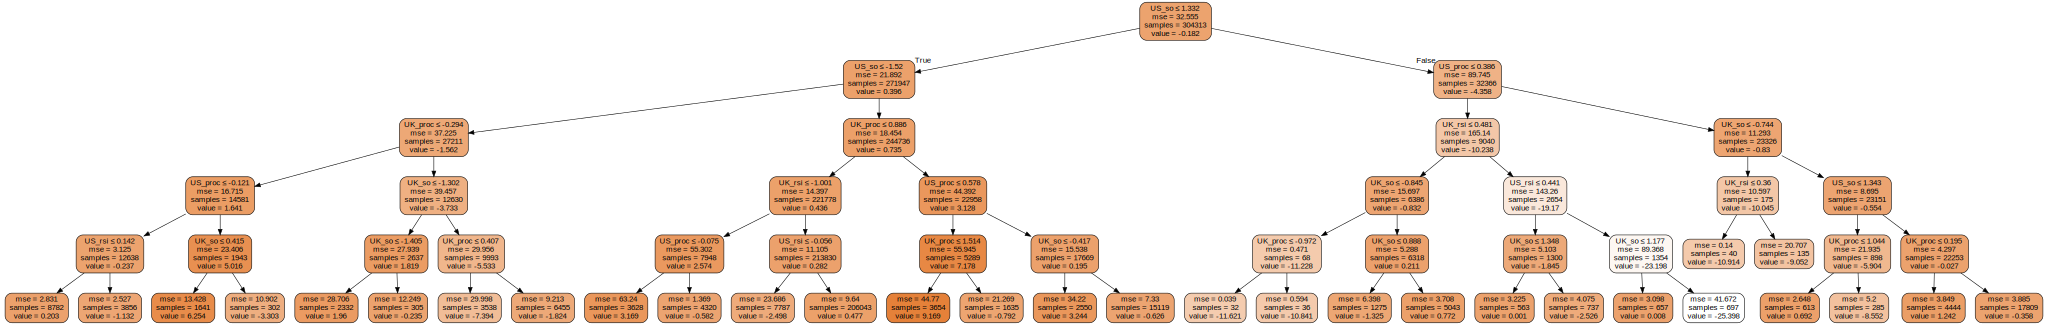

In [209]:
import graphviz 

dot_data = tree.export_graphviz(model, out_file="tree.dot", max_depth=None, 
                                feature_names=X.columns.values, class_names=None, label="all", 
                                filled=True, leaves_parallel=False, impurity=True, 
                                node_ids=False, proportion=False, rotate=False, 
                                rounded=False, special_characters=False, precision=3) 


graph = graphviz.Source(dot_data) 
dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names=X.columns.values,  
                         class_names="Arb deltas",  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 


In [202]:
# Decision trees Regression Gridsearch

from sklearn.tree import DecisionTreeRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

X=dataDF[['US_rsi','UK_rsi','US_so','UK_so','US_proc','UK_proc','US_macd_signal','UK_macd_signal']]
Y=dataDF['arb_move']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)

model = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=None, min_samples_split=10, min_samples_leaf=10, 
         min_weight_fraction_leaf=0.001, max_features=None, random_state=None, max_leaf_nodes=None, 
         min_impurity_decrease=0.0, min_impurity_split=None, presort=False)

estimators = [('clf',model )]
pipeline = Pipeline(estimators)


parameters = {
    'clf__max_depth': (2,4,6),
    'clf__min_samples_split': (2,3),
    'clf__min_samples_leaf': (1,2)
}

grid_search = GridSearchCV(pipeline, parameters, scoring=None, fit_params=None, n_jobs=1, iid=True, 
                           refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score='raise')

grid_search.fit(X_train,Y_train)



print 'Best score: %0.3f' % grid_search.best_score_
print 'Best parameters set: '
best_parameters=grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()): 
    print '\t%s: %r' % (param_name, best_parameters[param_name])
    
predictions = grid_search.predict(X_test)


print grid_search.best_estimator_
print grid_search.best_score_
print grid_search.best_params_
print grid_search.scorer_
grid_search.get_params
grid_search.score(X_test,Y_test)



Best score: 0.137
Best parameters set: 
	clf__max_depth: 6
	clf__min_samples_leaf: 1
	clf__min_samples_split: 2
Pipeline(memory=None,
     steps=[('clf', DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.001,
           presort=False, random_state=None, splitter='best'))])
0.137348139759
{'clf__max_depth': 6, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
<function _passthrough_scorer at 0x7fde487880c8>


0.13260138595455662

In [21]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier

X=dataDF[['US_rsi','UK_rsi','US_so','UK_so','US_proc','UK_proc','US_macd_signal','UK_macd_signal']]
Y=[1 if x>0 else 0 for x in dataDF['arb_move']] 


X_train, X_test, Y_train, Y_test = train_test_split(X,Y)



pipeline = Pipeline([('clf', RandomForestClassifier(criterion='entropy'))])

parameters = {
    'clf__n_estimators': (2,4),
    'clf__max_depth': (5,10,20),
    'clf__min_samples_split': (2,3,4),
    'clf__min_samples_leaf': (1,2,3)
}

grid_search = GridSearchCV(pipeline,parameters,n_jobs=1,verbose=1,scoring='f1')

grid_search.fit(X_train,Y_train)

print 'Best score: %0.3f' % grid_search.best_score_

print 'Best parameters set: '
best_parameters=grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()): 
    print '\t%s: %r' % (param_name, best_parameters[param_name])
    
predictions = grid_search.predict(X_test)
print classification_report(Y_test,predictions)


Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:  1.9min finished


Best score: 0.888
Best parameters set: 
	clf__max_depth: 20
	clf__min_samples_leaf: 1
	clf__min_samples_split: 4
	clf__n_estimators: 4
             precision    recall  f1-score   support

          0       0.88      0.90      0.89     52604
          1       0.89      0.87      0.88     49701

avg / total       0.89      0.89      0.89    102305



In [24]:
# Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

X=dataDF[['US_rsi','UK_rsi','US_so','UK_so','US_proc','UK_proc','US_macd_signal','UK_macd_signal']]
Y=dataDF['arb_move'] 
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)

model=RandomForestRegressor()


pipeline = Pipeline([('clf', model)])
parameters = {
    'clf__n_estimators': (2,4,5),
    'clf__max_depth': (2,4,5),
    'clf__min_samples_split': (2,3),
    'clf__min_samples_leaf': (1,2)
}

grid_search = GridSearchCV(pipeline,parameters,n_jobs=1)

grid_search.fit(X_train,Y_train)

print 'Best score: %0.3f' % grid_search.best_score_

print 'Best parameters set: '
best_parameters=grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()): 
    print '\t%s: %r' % (param_name, best_parameters[param_name])
    
predictions=grid_search.predict(X_test)
Y_test=Y_test.astype('int')
predictions=predictions.astype('int')

print classification_report(Y_test,predictions)

    

Best score: 0.126
Best parameters set: 
	clf__max_depth: 5
	clf__min_samples_leaf: 1
	clf__min_samples_split: 3
	clf__n_estimators: 4
             precision    recall  f1-score   support

        -28       0.00      0.00      0.00         6
        -27       0.00      0.00      0.00        36
        -26       0.00      0.00      0.00        30
        -25       0.00      0.00      0.00         5
        -14       0.00      0.00      0.00        16
        -13       0.00      0.00      0.00        45
        -12       0.00      0.00      0.00        56
        -11       0.00      0.00      0.00        84
        -10       0.00      0.00      0.00       104
         -9       0.00      0.00      0.00       117
         -8       0.00      0.00      0.00       158
         -7       0.00      0.00      0.00       165
         -6       0.00      0.00      0.00       147
         -5       0.00      0.00      0.00       176
         -4       0.00      0.00      0.00       332
         -3      

In [25]:
# regression decision tree
X=dataDF[['US_rsi','UK_rsi','US_so','UK_so','US_proc','UK_proc','US_macd_signal','UK_macd_signal']]
Y=dataDF[['arb_move']]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)

clf=tree.DecisionTreeRegressor(max_depth=10)
clf=clf.fit(X_train,Y_train)
prediction_raw=clf.predict(X_test)
#prediction=[1 if x[2]==1 else 0 if x[1]==1 else -1 for x in prediction_raw]

prediction_raw.max()

plt.scatter(Y_test,prediction_raw)
plt.ylabel('prediction arb move')
plt.xlabel('actual arb move')
plt.show()

KeyboardInterrupt: 

In [214]:
# XOR with multilayer perceptrons

from sklearn.cross_validation import train_test_split
from sklearn.neural_network import MultilayerPerceptronClassifier
y=[0,1,1,0]*1000
x=[[0,0],[0,1],[1,0],[1,1]]*1000
X_train, X_test, Y_train, Y_test = train_test_split(x,y
                                                   )

ImportError: cannot import name MultilayerPerceptronClassifier

In [ ]:
'''
inputs: tons of securities: trades, prices

Signals: ADX, distance from ema, distance from vwap, other technicals (cvd)

Models: svd, decision trees, random forests, neural nets

prediction: classification (buy, sell), but weighted by the strength of the ensuing move (minimu move?)

Parameter grid, cross validation: optimise meta parameters

Evaluation: precision (more important than recall or f1)

Some models can tell you which features are most predictive

OMS: each update, do i still want to be long or do i want to get flat (gets a signal)

Generic model for alt coin model, normalized every single feature by coin (stdev, coin feature)

parameter; how much  i trade beta, (how much altcoin i will have on)

lot of correlated features isn't a problem (random forest classification, logistic regression or classification)

time scale: 1h to 6 h (y values 10 min to 90 min)

model updated from feeds of data

the more data the better, maybe 6 month (as long as regime is the same)

any particular coin, what is the direction gonna be

volume:how much i am willing to trade and hold as function of rolling volume

looking at 100s of coins, figuring out which one is cheap

filter out low volume coins (2 exchanges(not only US exchanges), 100 to 250, avg 150) 

You buy an altcoin and then wait for the model to tell you to sell (You hold as long as the model doesn t tell you to sell)
(it can go up 10% without going out of it)

Classification: price will go up (1) or down (0)

XG Boost (regression trees instead of classification trees, gradien descent on adding another tree, if I add this tree, does it help 
my cost function)

each coin predicition is independent

When it wants to buy everything, don t buy everything like crazy


directional trading

'''

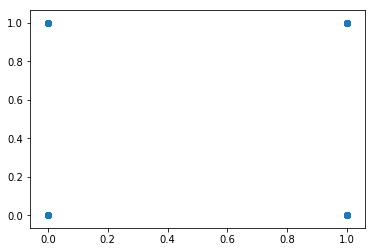

In [19]:
#XG boost

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

X=dataDF[['US_rsi','UK_rsi','US_so','UK_so','US_proc','UK_proc','US_macd_signal','UK_macd_signal']]
# Y=dataDF['arb_move'] 
Y=[1 if x>0 else 0 for x in dataDF['arb_move']] 
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)

model=XGBClassifier()
model.fit(X_train, Y_train)

#Y_pred= model.predict_proba(X_test)
Y_pred= model.predict(X_test)
Y_pred
accuracy=accuracy_score(Y_test, Y_pred)
accuracy

plt.scatter(Y_pred,Y_test)
plt.show()



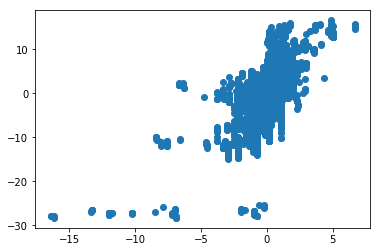

In [13]:
#XG boost

from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split

X=dataDF[['US_rsi','UK_rsi','US_so','UK_so','US_proc','UK_proc','US_macd_signal','UK_macd_signal']]
# Y=dataDF['arb_move'] 
Y=dataDF['arb_move'] 
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)

model=XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', 
                   booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, 
                   subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                   scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None)


model.fit(X_train, Y_train)

#Y_pred= model.predict_proba(X_test)
Y_pred= model.predict(X_test)

plt.scatter(Y_pred,Y_test)
plt.show()